Github link:
https://github.com/shoman8/Stat6289

In [1]:
# Import all necessary libraries
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import os
import sys
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Observing the data below, we can see that shares are only traded five days a week (Monday - Friday).  Therefore, a 7 day lag will go back 5 trading days.  Similarly, a 14 day lag will go back 10 trading days.

In [3]:
# Import the data
df=pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
df.head(11)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000
5,2015-07-17,54.500000,55.108002,53.650002,54.931999,54.931999,25020500
6,2015-07-20,55.000000,57.330002,54.507999,56.452000,56.452000,24892500
7,2015-07-21,54.009998,54.700001,53.310001,53.354000,53.354000,30543500
8,2015-07-22,52.254002,53.888000,52.172001,53.574001,53.574001,15525000
9,2015-07-23,53.930000,53.980000,53.054001,53.439999,53.439999,11136000


The data below contains dates starting from the beginning of the data (7/10/2015) all the way through to October 1st, 2020 for the purpose of forecasting.

In [4]:
# Import data of dates from 7/10/2015 - 10/1/2020
df2=pd.read_csv("hw2_dates.csv")
df2

,Date
0,7/10/15
1,7/13/15
2,7/14/15
3,7/15/15
4,7/16/15
...,...
1314,9/27/20
1315,9/28/20
1316,9/29/20
1317,9/30/20


In [5]:
# Split into Training and Testing sets
# First 800 observations go to Training
training_set = df.iloc[:800, 1:2].values
# Remaining 459 observations go to Testing
test_set = df.iloc[800:, 1:2].values

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# One day lag is the previous trading day.
X_train_1day = []
y_train_1day = []
for i in range(1, 800):
    X_train_1day.append(training_set_scaled[i-1:i, 0])
    y_train_1day.append(training_set_scaled[i, 0])
X_train_1day, y_train_1day = np.array(X_train_1day), np.array(y_train_1day)
X_train_1day = np.reshape(X_train_1day, (X_train_1day.shape[0], X_train_1day.shape[1], 1))
print(X_train_1day.shape)

# 7 day lag is the previous 5 trading days to form a 7 day calendar lag.
X_train_7day = []
y_train_7day = []
for i in range(5, 800):
    X_train_7day.append(training_set_scaled[i-5:i, 0])
    y_train_7day.append(training_set_scaled[i, 0])
X_train_7day, y_train_7day = np.array(X_train_7day), np.array(y_train_7day)
X_train_7day = np.reshape(X_train_7day, (X_train_7day.shape[0], X_train_7day.shape[1], 1))
print(X_train_7day.shape)

# 14 day lag is the previous 10 trading days to form a 14 day calendar lag.
X_train_14day = []
y_train_14day = []
for i in range(10, 800):
    X_train_14day.append(training_set_scaled[i-10:i, 0])
    y_train_14day.append(training_set_scaled[i, 0])
X_train_14day, y_train_14day = np.array(X_train_14day), np.array(y_train_14day)
X_train_14day = np.reshape(X_train_14day, (X_train_14day.shape[0], X_train_14day.shape[1], 1))
print(X_train_14day.shape)


(799, 1, 1)
(795, 5, 1)
(790, 10, 1)


I will utilize three models, all with 1 day, 7 day, and 14 day lags.

1. Model 1: Base Model - 50 Neurons and 4 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.  MSE Loss Function and ADAM optimizer.

2. Model 2: 6 layer Model - 50 Neurons and 6 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.  MSE Loss Function and ADAM optimizer.

3. Model 3: High Dropout Model - 50 Neurons and 4 hidden layers. 0.4 dropout rate. Assign one neuron to output layer.  MSE Loss Function and ADAM optimizer.

In [7]:
# Model 1: Base Model - 50 Neurons and 4 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   1 day lag

# MSE loss function and ADAM optimizer
model1_1day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model1_1day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_1day.shape[1], 1)))
model1_1day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model1_1day.add(LSTM(units = 50, return_sequences = True))
model1_1day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model1_1day.add(LSTM(units = 50, return_sequences = True))
model1_1day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model1_1day.add(LSTM(units = 50))
model1_1day.add(Dropout(0.2))
# Adding the output layer
model1_1day.add(Dense(units = 1))

# Compiling the RNN
model1_1day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model1_1day.fit(X_train_1day, y_train_1day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 7s 6ms/step - loss: 0.2761
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.1071
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0409
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0298
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 11/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 12/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 13/100
25/25 [=================

In [8]:
# Model 1: Base Model - 50 Neurons and 4 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   7 day lag

# MSE loss function and ADAM optimizer
model1_7day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model1_7day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_7day.shape[1], 1)))
model1_7day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model1_7day.add(LSTM(units = 50, return_sequences = True))
model1_7day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model1_7day.add(LSTM(units = 50, return_sequences = True))
model1_7day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model1_7day.add(LSTM(units = 50))
model1_7day.add(Dropout(0.2))
# Adding the output layer
model1_7day.add(Dense(units = 1))

# Compiling the RNN
model1_7day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model1_7day.fit(X_train_7day, y_train_7day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 15s 14ms/step - loss: 0.1365
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0309
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0135
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0083
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0083
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0072
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0075
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0068
Epoch 9/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 10/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0069
Epoch 11/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0064
Epoch 12/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0063
Epoch 13/100
25/25 [====

In [9]:
# Model 1: Base Model - 50 Neurons and 4 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   14 day lag

# MSE loss function and ADAM optimizer
model1_14day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model1_14day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_14day.shape[1], 1)))
model1_14day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model1_14day.add(LSTM(units = 50, return_sequences = True))
model1_14day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model1_14day.add(LSTM(units = 50, return_sequences = True))
model1_14day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model1_14day.add(LSTM(units = 50))
model1_14day.add(Dropout(0.2))
# Adding the output layer
model1_14day.add(Dense(units = 1))

# Compiling the RNN
model1_14day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model1_14day.fit(X_train_14day, y_train_14day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 7s 21ms/step - loss: 0.0998
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0208
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0114
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0102
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0098
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0094
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0097
Epoch 8/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0110
Epoch 9/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0089
Epoch 10/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0080
Epoch 11/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0083
Epoch 12/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0087
Epoch 13/100
25/25 [=====

In [10]:
# Model 2: 6 layer Model - 50 Neurons and 6 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   1 day lag

# MSE loss function and ADAM optimizer
model2_1day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_1day.shape[1], 1)))
model2_1day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50, return_sequences = True))
model2_1day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50, return_sequences = True))
model2_1day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50, return_sequences = True))
model2_1day.add(Dropout(0.2))
# Adding a fifth LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50, return_sequences = True))
model2_1day.add(Dropout(0.2))
# Adding a sixth LSTM layer and some Dropout regularisation
model2_1day.add(LSTM(units = 50))
model2_1day.add(Dropout(0.2))
# Adding the output layer
model2_1day.add(Dense(units = 1))

# Compiling the RNN
model2_1day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model2_1day.fit(X_train_1day, y_train_1day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 9s 9ms/step - loss: 0.2803
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 0.1209
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0541
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0425
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 8/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 9/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 10/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 11/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 12/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 13/100
25/25 [================

In [11]:
# Model 2: 6 layer Model - 50 Neurons and 6 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   7 day lag

# MSE loss function and ADAM optimizer
model2_7day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_7day.shape[1], 1)))
model2_7day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50, return_sequences = True))
model2_7day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50, return_sequences = True))
model2_7day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50, return_sequences = True))
model2_7day.add(Dropout(0.2))
# Adding a fifth LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50, return_sequences = True))
model2_7day.add(Dropout(0.2))
# Adding a sixth LSTM layer and some Dropout regularisation
model2_7day.add(LSTM(units = 50))
model2_7day.add(Dropout(0.2))
# Adding the output layer
model2_7day.add(Dense(units = 1))

# Compiling the RNN
model2_7day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model2_7day.fit(X_train_7day, y_train_7day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 9s 19ms/step - loss: 0.1552
Epoch 2/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0498
Epoch 3/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0191
Epoch 4/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087
Epoch 7/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0084
Epoch 8/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0078
Epoch 9/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0078
Epoch 10/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0072
Epoch 11/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0072
Epoch 12/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0068
Epoch 13/100
25/25 [=====

In [12]:
# Model 2: 6 layer Model - 50 Neurons and 6 hidden layers. 0.2 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   14 day lag

# MSE loss function and ADAM optimizer
model2_14day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_14day.shape[1], 1)))
model2_14day.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50, return_sequences = True))
model2_14day.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50, return_sequences = True))
model2_14day.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50, return_sequences = True))
model2_14day.add(Dropout(0.2))
# Adding a fifth LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50, return_sequences = True))
model2_14day.add(Dropout(0.2))
# Adding a sixth LSTM layer and some Dropout regularisation
model2_14day.add(LSTM(units = 50))
model2_14day.add(Dropout(0.2))
# Adding the output layer
model2_14day.add(Dense(units = 1))

# Compiling the RNN
model2_14day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model2_14day.fit(X_train_14day, y_train_14day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 10s 34ms/step - loss: 0.1085
Epoch 2/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0256
Epoch 3/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0118
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0102
Epoch 5/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0096
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0093
Epoch 7/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0107
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0095
Epoch 9/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0112
Epoch 10/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0088
Epoch 11/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0091
Epoch 12/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0098
Epoch 13/100
25/25 [====

In [13]:
# Model 3: High Dropout Model - 50 Neurons and 4 hidden layers. 0.4 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   1 day lag

# MSE loss function and ADAM optimizer
model3_1day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model3_1day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_1day.shape[1], 1)))
model3_1day.add(Dropout(0.4))
# Adding a second LSTM layer and some Dropout regularisation
model3_1day.add(LSTM(units = 50, return_sequences = True))
model3_1day.add(Dropout(0.4))
# Adding a third LSTM layer and some Dropout regularisation
model3_1day.add(LSTM(units = 50, return_sequences = True))
model3_1day.add(Dropout(0.4))
# Adding a fourth LSTM layer and some Dropout regularisation
model3_1day.add(LSTM(units = 50))
model3_1day.add(Dropout(0.4))
# Adding the output layer
model3_1day.add(Dense(units = 1))

# Compiling the RNN
model3_1day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model3_1day.fit(X_train_1day, y_train_1day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 6s 5ms/step - loss: 0.2845
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.1309
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0454
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0299
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0150
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 11/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 12/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 13/100
25/25 [=================

In [14]:
# Model 3: High Dropout Model - 50 Neurons and 4 hidden layers. 0.4 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   7 day lag

# MSE loss function and ADAM optimizer
model3_7day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model3_7day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_7day.shape[1], 1)))
model3_7day.add(Dropout(0.4))
# Adding a second LSTM layer and some Dropout regularisation
model3_7day.add(LSTM(units = 50, return_sequences = True))
model3_7day.add(Dropout(0.4))
# Adding a third LSTM layer and some Dropout regularisation
model3_7day.add(LSTM(units = 50, return_sequences = True))
model3_7day.add(Dropout(0.4))
# Adding a fourth LSTM layer and some Dropout regularisation
model3_7day.add(LSTM(units = 50))
model3_7day.add(Dropout(0.4))
# Adding the output layer
model3_7day.add(Dense(units = 1))

# Compiling the RNN
model3_7day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model3_7day.fit(X_train_7day, y_train_7day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 6s 15ms/step - loss: 0.1346
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0323
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 4/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0144
Epoch 5/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0126
Epoch 6/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0135
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0123
Epoch 8/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 9/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0101
Epoch 10/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0098
Epoch 11/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0100
Epoch 12/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0087
Epoch 13/100
25/25 [=====

In [15]:
# Model 3: High Dropout Model - 50 Neurons and 4 hidden layers. 0.4 dropout rate. Assign one neuron to output layer.
#                       MSE Loss Function and ADAM optimizer
#   14 day lag

# MSE loss function and ADAM optimizer
model3_14day = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model3_14day.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_14day.shape[1], 1)))
model3_14day.add(Dropout(0.4))
# Adding a second LSTM layer and some Dropout regularisation
model3_14day.add(LSTM(units = 50, return_sequences = True))
model3_14day.add(Dropout(0.4))
# Adding a third LSTM layer and some Dropout regularisation
model3_14day.add(LSTM(units = 50, return_sequences = True))
model3_14day.add(Dropout(0.4))
# Adding a fourth LSTM layer and some Dropout regularisation
model3_14day.add(LSTM(units = 50))
model3_14day.add(Dropout(0.4))
# Adding the output layer
model3_14day.add(Dense(units = 1))

# Compiling the RNN
model3_14day.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model3_14day.fit(X_train_14day, y_train_14day, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 6s 23ms/step - loss: 0.1006
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0267
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0166
Epoch 4/100
25/25 [==============================] - 1s 25ms/step - loss: 0.0152
Epoch 5/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0151
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0124
Epoch 7/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0129
Epoch 8/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0134
Epoch 9/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0110
Epoch 10/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0115
Epoch 11/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0121
Epoch 12/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0124
Epoch 13/100
25/25 [=====

In [28]:
# Prepare the test data
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs_1day = dataset_total[799:].values
inputs_7day = dataset_total[795:].values
inputs_14day = dataset_total[790:].values
inputs_1day = inputs_1day.reshape(-1,1)
inputs_7day = inputs_7day.reshape(-1,1)
inputs_14day = inputs_14day.reshape(-1,1)
inputs_1day = sc.transform(inputs_1day)
inputs_7day = sc.transform(inputs_7day)
inputs_14day = sc.transform(inputs_14day)

# 1 day lag
X_test_1day = []
for i in range(1, 460):
    X_test_1day.append(inputs_1day[i-1:i, 0])
X_test_1day = np.array(X_test_1day)
X_test_1day = np.reshape(X_test_1day, (X_test_1day.shape[0], X_test_1day.shape[1], 1))
print(X_test_1day.shape)
# (459, 1, 1)

# 7 day lag
X_test_7day = []
for i in range(5, 464):
    X_test_7day.append(inputs_7day[i-5:i, 0])
X_test_7day = np.array(X_test_7day)
X_test_7day = np.reshape(X_test_7day, (X_test_7day.shape[0], X_test_7day.shape[1], 1))
print(X_test_7day.shape)
# (459, 5, 1)

# 14 day lag
X_test_14day = []
for i in range(10, 469):
    X_test_14day.append(inputs_14day[i-10:i, 0])
X_test_14day = np.array(X_test_14day)
X_test_14day = np.reshape(X_test_14day, (X_test_14day.shape[0], X_test_14day.shape[1], 1))
print(X_test_14day.shape)
# (459, 10, 1)


(459, 1, 1)
(459, 5, 1)
(459, 10, 1)


In [29]:
# Perform predictions on the test dataset

# Model 1
#   1 day lag
predicted_stock_price1_1day = model1_1day.predict(X_test_1day)
predicted_stock_price1_1day = sc.inverse_transform(predicted_stock_price1_1day)

#   7 day lag
predicted_stock_price1_7day = model1_7day.predict(X_test_7day)
predicted_stock_price1_7day = sc.inverse_transform(predicted_stock_price1_7day)

#   14 day lag
predicted_stock_price1_14day = model1_14day.predict(X_test_14day)
predicted_stock_price1_14day = sc.inverse_transform(predicted_stock_price1_14day)

# Model 2
#   1 day lag
predicted_stock_price2_1day = model2_1day.predict(X_test_1day)
predicted_stock_price2_1day = sc.inverse_transform(predicted_stock_price2_1day)

#   7 day lag
predicted_stock_price2_7day = model2_7day.predict(X_test_7day)
predicted_stock_price2_7day = sc.inverse_transform(predicted_stock_price2_7day)

#   14 day lag
predicted_stock_price2_14day = model2_14day.predict(X_test_14day)
predicted_stock_price2_14day = sc.inverse_transform(predicted_stock_price2_14day)

# Model 3
#   1 day lag
predicted_stock_price3_1day = model3_1day.predict(X_test_1day)
predicted_stock_price3_1day = sc.inverse_transform(predicted_stock_price3_1day)

#   7 day lag
predicted_stock_price3_7day = model3_7day.predict(X_test_7day)
predicted_stock_price3_7day = sc.inverse_transform(predicted_stock_price3_7day)

#   14 day lag
predicted_stock_price3_14day = model3_14day.predict(X_test_14day)
predicted_stock_price3_14day = sc.inverse_transform(predicted_stock_price3_14day)


In [30]:
# Perform forecast to October 1st 2020.  This is 60 trading days into the future
# Concatenate the forecasts to the test predictions

# Model 1
#   1 day lag
first_pred1_1day = model1_1day.predict(X_test_1day[-1:,])
forecast1_1day_60 = []
forecast1_1day_60.append(first_pred1_1day)
for i in range(59):
  x = forecast1_1day_60[-1]
  pred = model1_1day.predict(x)
  forecast1_1day_60.append(pred)
forecast1_1day_60 = np.array(forecast1_1day_60)
forecast1_1day_60 = forecast1_1day_60[:, :, 0]
forecast1_1day_60 = sc.inverse_transform(forecast1_1day_60)
predicted_stock_price1_1day = np.append(predicted_stock_price1_1day, forecast1_1day_60)

# Model 2
#   1 day lag
first_pred2_1day = model2_1day.predict(X_test_1day[-1:,])
forecast2_1day_60 = []
forecast2_1day_60.append(first_pred2_1day)
for i in range(59):
  x = forecast2_1day_60[-1]
  pred = model2_1day.predict(x)
  forecast2_1day_60.append(pred)
forecast2_1day_60 = np.array(forecast2_1day_60)
forecast2_1day_60 = forecast2_1day_60[:, :, 0]
forecast2_1day_60 = sc.inverse_transform(forecast2_1day_60)
predicted_stock_price2_1day = np.append(predicted_stock_price2_1day, forecast2_1day_60)

# Model 3
#   1 day lag
first_pred3_1day = model3_1day.predict(X_test_1day[-1:,])
forecast3_1day_60 = []
forecast3_1day_60.append(first_pred3_1day)
for i in range(59):
  x = forecast3_1day_60[-1]
  pred = model3_1day.predict(x)
  forecast3_1day_60.append(pred)
forecast3_1day_60 = np.array(forecast3_1day_60)
forecast3_1day_60 = forecast3_1day_60[:, :, 0]
forecast3_1day_60 = sc.inverse_transform(forecast3_1day_60)
predicted_stock_price3_1day = np.append(predicted_stock_price3_1day, forecast3_1day_60)

Visualizing the results
The final day in the TSLA.csv dataset is 7/9/2020.  So all values between 7/10/2020 and 10/1/2020 are forecasted in the predicted lines.  This is why the real price (red) line stops before the predicted (blue) line.

**Test Results Discussion:**

**Overall**: 

All three models do a very good job predicting the prices of the test dataset from about September 2018 until about March 2020, the start of the COVID-19 pandemic.  In March of 2020, the prices plummeted, and then rebounded dramatically in April of 2020 and continued to increase indefinitely.  All of the models failed to capture the dramatic swing in prices.

**Pandemic Results (Post March 2020):**

Model 1: the 1 day lag model actually moves in the opposite direction of the true price changes.  When prices go up, predictions drop, and vice versa.  The 7 day lag oscillates very quickly without moving up or down in any specific trend.  The 14 day lag model performs simlarly to the 7 day model, but it does seem to at least capture the overall upward trend.

Model 2: All three lags perform about the same during the pandemic.  The predictons stay very steady at around $75.  The models fail to capture any volatility or the general upward trend post April 2020.  My conclusion is that the model is oversaturated and is failing to converge to any meaningful result, meaning that the 6 hidden layer model was not ideal in this situation.

Model 3: The model three results perform very similarly to the Model 1 results.  The 1 day lag moves in the opposite direction of the true price changes, the 7 day lag captures volatility without a trend, and the 14 day lag captures the volatitility as well as the downward trend in March 2020 followed by upward trend in April 2020.  I would say that the 14 day lag in Model 3 performs the best out of all models during the pandemic, indicating that the higher drop out rate was beneficial.

**Forecasting Results:**

I forecasted 60 days into the future to obtain results as late as October 2020.  The TSLA data provides data into July 2020, so I needed to forecast almost two months into the future.  I forecasted my 1 day lag models for all three models.  All three performed about the same which saw a steady decline which does not accurately reflect the prior increase in price.  Moreover, looking at the true Telsa prices during the August, September, and October 2020 time period, does not reflect reality.  The prices continued to increase.  Forecasting is inherently challenging, so it's not surprising that the models did not perform well predicting into the future.

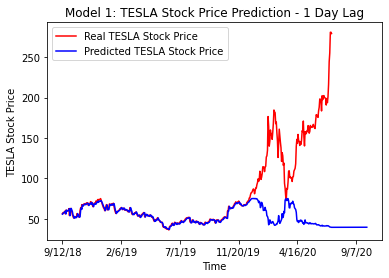

In [41]:
# Visualising the results
# Model 1
#   1 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df2.loc[800:, 'Date'],predicted_stock_price1_1day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 1: TESLA Stock Price Prediction - 1 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

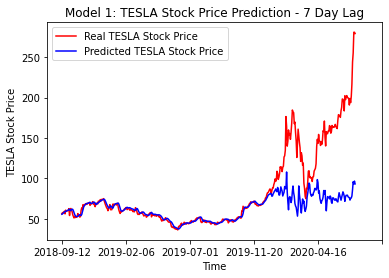

In [42]:
# Model 1
#   7 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price1_7day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 1: TESLA Stock Price Prediction - 7 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

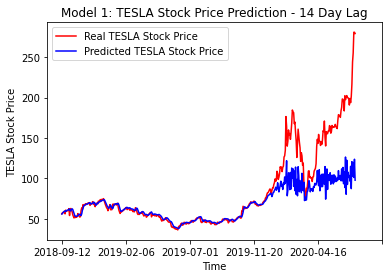

In [33]:
# Model 1
#   14 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price1_14day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 1: TESLA Stock Price Prediction - 14 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

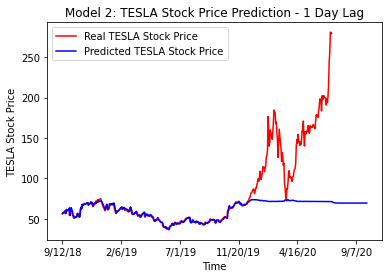

In [35]:
# Model 2
#   1 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df2.loc[800:, 'Date'],predicted_stock_price2_1day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 2: TESLA Stock Price Prediction - 1 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

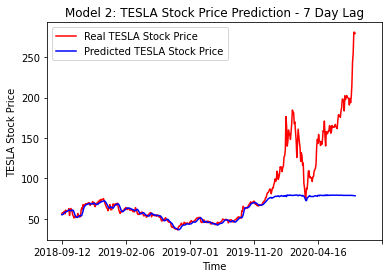

In [36]:
# Model 2
#   7 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price2_7day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 2: TESLA Stock Price Prediction - 7 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

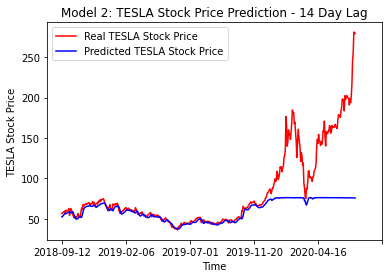

In [37]:
# Model 2
#   14 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price2_14day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 2: TESLA Stock Price Prediction - 14 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

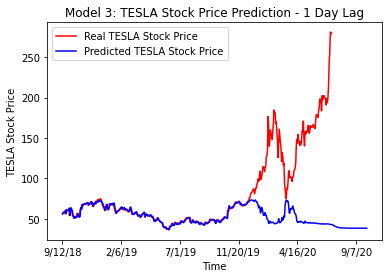

In [38]:
# Model 3
#   1 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df2.loc[800:, 'Date'],predicted_stock_price3_1day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 3: TESLA Stock Price Prediction - 1 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

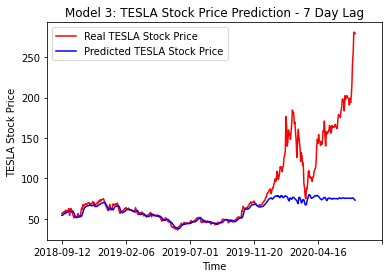

In [39]:
# Model 3
#   7 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price3_7day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 3: TESLA Stock Price Prediction - 7 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

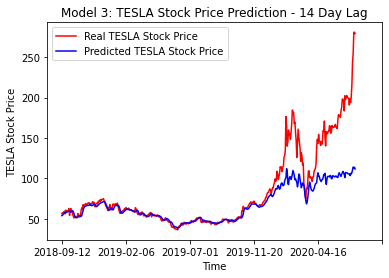

In [40]:
# Model 3
#   14 Day lag
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price3_14day, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,519,100))
plt.title('Model 3: TESLA Stock Price Prediction - 14 Day Lag')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()